# **Основные этапы работы:**
## **Этап 0. Установка и настройка оболочки для работы с языком Python**
Загрузка необходимых библиотек для выполнения лаборатрных работ:

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.models import Model

## **Этап 1. Построение сверточной нейронной сети для распознавания объектов из базы данных ImageNet.**

**Целью данного этапа** курсовой работы является создание сверточного многокатегориального классификатора изображений из набора данных ImageNet.
Пошаговая реализация поставленной цели включает:

1. Загрузка 10 классов изображений из набора данных ImageNet согласно
варианту:

Загрузка данных осуществляется при помощи подключения к Google Drive, где хранится архив с данными. Затем этот архив распаковывается в рабочую директорию.

In [5]:
from google.colab import drive
drive.mount ('/drive')

Mounted at /drive


In [3]:
!cd "/drive/MyDrive/BD"
!unzip "/drive/MyDrive/BD/Москаленко.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Москаленко/Leopard/n02128385_13499.JPEG  
  inflating: Москаленко/Leopard/n02128385_13502.JPEG  
  inflating: Москаленко/Leopard/n02128385_13507.JPEG  
  inflating: Москаленко/Leopard/n02128385_13545.JPEG  
  inflating: Москаленко/Leopard/n02128385_1357.JPEG  
  inflating: Москаленко/Leopard/n02128385_13575.JPEG  
  inflating: Москаленко/Leopard/n02128385_13579.JPEG  
  inflating: Москаленко/Leopard/n02128385_13582.JPEG  
  inflating: Москаленко/Leopard/n02128385_13623.JPEG  
  inflating: Москаленко/Leopard/n02128385_13625.JPEG  
  inflating: Москаленко/Leopard/n02128385_13630.JPEG  
  inflating: Москаленко/Leopard/n02128385_13690.JPEG  
  inflating: Москаленко/Leopard/n02128385_13703.JPEG  
  inflating: Москаленко/Leopard/n02128385_13760.JPEG  
  inflating: Москаленко/Leopard/n02128385_13768.JPEG  
  inflating: Москаленко/Leopard/n02128385_13778.JPEG  
  inflating: Москаленко/Leopard/n02128385_13785.JPEG 

In [4]:
drive.mount('/content/drive')#/content/drive/MyDrive /content/drive

Mounted at /content/drive



ImageNet - представляет собой большую визуальную базу данных, предназначенную для использования в исследованиях программного обеспечения для распознавания визуальных объектов. Более 14 миллионов изображения были аннотированы проектом от руки, чтобы указать, какие объекты изображены, и по крайней мере на одном миллионе изображений также предусмотрены ограничивающие рамки. ImageNet содержит более 20 000 категорий, с типичной категорией, состоящей из нескольких сотен изображений. Набор данных ImageNet организован с помощью иерархии WordNet. Каждый узел иерархии представляет собой категорию, а каждая категория описывается синсетами (коллекцией синонимичных терминов). Изображения в ImageNet аннотированы одним или несколькими синсетами, что обеспечивает богатый ресурс для обучения моделей распознавания различных объектов и их взаимосвязей.

После успешной загрузки данных происходит их обработка в функции *proc_img()*. Функция извлекает метки изображений из путей к файлам. Затем создается DataFrame, содержащий пути к файлам изображений и соответствующие им метки. Строки в этом DataFrame перемешиваются случайным образом.

In [5]:
def proc_img(filepath):
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)
    return df

train_dir = Path('/content/Москаленко')
filepaths = list(train_dir.glob(r'**/*.JPEG'))
df = proc_img(filepaths)

Number of pictures: 13000

Number of different labels: 10



,Filepath,Label
0,/content/Москаленко/Dragonfly/n02268443_23490....,Dragonfly
1,/content/Москаленко/Hymenoptera/n02206856_2666...,Hymenoptera
2,/content/Москаленко/Foxes/n02120505_12077.JPEG,Foxes
3,/content/Москаленко/Dragonfly/n02268443_16009....,Dragonfly
4,/content/Москаленко/Riesenschnauzer/n02097130_...,Riesenschnauzer


Определим количество уникальных меток в наборе данных, а также общее количество изображений.



In [ ]:
NUM_CLASSES = len(df.Label.unique())
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {NUM_CLASSES}\n')
df.head(5)

Визуалируем фотографии каждого класса:


In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i])
    ax.axis("off")

plt.show()

### Подготовка и дополнение данных для модели

2. Разделение данных на обучающий и тестовый наборы:

Используя функцию train_test_split из библиотеки sklearn, DataFrame  разделяется на обучающую и тестовую множества в соотношении 80 на 20. Обучающая выборка сохраняется в train_df, тестовая – в test_df.

In [14]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)

3. Создание генератора изображений размерности 200x200 или 220x220:

После загрузки данных необходимо разделить их на обучающие, валидационные и тестовые множества. Для этого используется вспомогательная функция *prepare_data()*. Функция определяет путь к директории с изображениями и создает список всех файлов с расширением .JPEG в этой директории и ее подкаталогах. Создается объект ImageDataGenerator с несколькими параметрами для аугментации данных (rotation_range, width_shift, height_shift, shear_range, zoom_range, horizontal_flip, fill_mode) и предварительной обработки изображений. ImageDataGenerator поможет модели выявить больше особенностей данных и достичь лучшей степени обобщения, ImageDataGenerator реализует подход создания дополнительных обучающих данных из имеющихся путем трансформации образцов множеством случайных преобразований, дающих правдоподобные изображения.
*   rotation_range — величина в градусах (0–180), диапазон, в котором будет осуществляться случайный поворот изображения;
*   width_shift и height_shift — диапазоны (в долях ширины и высоты), в пределах которых изображения смещаются по горизонтали и вертикали соответственно;
*   shear_range — для случайного применения сдвигового (shearing) преобразования;
*   zoom_range — для случайного изменения масштаба внутри изображений;
*   horizontal_flip — для случайного переворачивания половины изображения по горизонтали — подходит в случае отсутствия предположений о горизонтальной асимметрии;
*   fill_mode — стратегия заполнения вновь созданных пикселов, появляющихся после поворота или смещения по горизонтали/вертикали.

Этот объект будет использоваться для генерации обучающих и валидационных данных.

Далее создаются два генератора данных (train_data и valid_data) из DataFrame train_df, содержащего пути к файлам изображений и их метки. Генераторы настраиваются для работы с цветными изображениями и многоклассовой классификации. Они также разделяют данные на обучающую и валидационную выборки в соотношении 80/20. Создается еще один генератор данных test_data из DataFrame test_df для тестовых данных. Этот генератор не выполняет аугментацию данных. Функция извлекает метки классов и имена файлов из обучающего генератора данных. Она создает словарь new_class_dict, который сопоставляет целочисленные метки классов с их текстовыми названиями. На выходе функции получаем тренировочный, валидационный, тестовый генератор данных, а также словарь сопоставления номера класса с текстовой меткой.

Обучение сверточной нейронной сети с использованием генераторов расширения данных:

In [ ]:
def prepare_data(input_size):
    dir = '/content/Москаленко'
    filepaths = list(Path(dir).glob(r'**/*.JPEG'))


    train_data_generator = ImageDataGenerator(validation_split=0.2,
                            preprocessing_function=preprocess_input,
                            rotation_range=30,
                            zoom_range=0.15,
                            width_shift_range=0.2,# смещение по направлению x
                            height_shift_range=0.2,
                            shear_range=0.15, # сдвиговое преобразование
                            horizontal_flip=True, # случайное переворачивание половины изобр.
                            fill_mode="nearest") # заполнение пикселей

    train_data = train_data_generator.flow_from_dataframe(
                                train_df,
                                x_col='Filepath',
                                y_col='Label',
                                target_size=input_size,
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=32,
                                shuffle=True, # перемешка
                                seed=0,
                                subset='training')

    valid_data = train_data_generator.flow_from_dataframe(
                                train_df,
                                x_col='Filepath',
                                y_col='Label',
                                target_size=input_size,
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=32,
                                shuffle=True,
                                seed=0,
                                subset='validation')


    test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_data = test_data_generator.flow_from_dataframe(
                                dataframe=test_df,
                                x_col='Filepath',
                                y_col='Label',
                                target_size=input_size,
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=32,
                                shuffle=False)

    labels = train_data.labels
    file_names = train_data.filenames
    gen_length = len(labels)
    class_dict = train_data.class_indices
    new_class_dict = {}
    for key,value in class_dict.items(): # переварачиваем словарь, чтобы показать, что он имеет форму {integer label, class_name}
        new_class_dict[value] = key
    print()
    print("Classes:")
    for x in new_class_dict:
        print(x,":", new_class_dict[x])

    return train_data, valid_data, test_data, new_class_dict

4. Подготовка данных для передачи в нейронную сеть:

Переменная INPUT_SIZE определяет размер, до которого будут масштабироваться все изображения перед подачей их на вход модели. Так как даётся выбор, (200, 200) или (220, 220) пикселей, был сделан выбор в пользу (200, 200) пикселей.

In [15]:
INPUT_SIZE = (200, 200)
train_images, val_images, test_images, class_names = prepare_data(INPUT_SIZE)

Found 8320 validated image filenames belonging to 10 classes.
Found 2080 validated image filenames belonging to 10 classes.
Found 2600 validated image filenames belonging to 10 classes.

Classes:
0 : Dragonfly
1 : Foxes
2 : GoldenRetriever
3 : Holothurias
4 : Horses
5 : Hymenoptera
6 : Leopard
7 : Meerkat
8 : Riesenschnauzer
9 : YorkshireTerrier


Можно увидеть, что обнаружено 8320 тренировочных имен файлов изображений, 2080 проверочных имен файлов изображений, 2600 тестовых имен файлов изображений,принадлежащих к 10 классам,

5. В качестве базы для создания классификатора необходимо использовать сверточную основу уже обученной сети VGG16 (или ее аналогов). В зависимости от вычислительных возможностей необходимо проводить обучение либо только классификатора, либо дополнительно последнего сверточного блока сверточной основы. Весовые коэффициенты на остальных слоях следует заморозить. Критерием является достижение точности в 85 и более процентов.

В работе была выбрана модель *VGG16*

***VGG16***


Функция create_model определяет архитектуру модели. Она использует предварительно обученную модель *VGG16* в качестве базовой модели, загружая веса, обученные на наборе данных ImageNet. Базовая модель инициализируется без выходного полносвязного слоя *include_top=False*, поскольку мы будем добавлять свои собственные слои для классификации. Веса базовой модели замораживаются *base_model.trainable = False*, чтобы не менять предварительно обученные веса на начальном этапе обучения. Функция позволяет разморозить несколько последних слоев базовой модели для дообучения *fine_tune_layers*, устанавливая их *trainable=True*. Затем добавляются два полносвязных слоя с 128 нейронами и функцией активации *ReLU*. Выходной слой - полносвязный с 10 нейронами (предполагается 10 классов) и функцией активации *softmax* для получения распределения вероятностей принадлежности к каждому классу. Создается объект модели *Model*, объединяющий входы базовой модели и новые полносвязные слои. Модель компилируется с оптимизатором *Adam*, функцией потерь *categorical_crossentropy* (для задачи многоклассовой классификации), она определяет расстояние между распределениями вероятностей. и метрикой *accuracy*. Оптимизация *Adam* — это метод стохастического градиентного спуска, основанный на адаптивной оценке моментов первого и второго порядка.


*   Аргумент weights определяет источник весов для инициализации модели.
*   Аргумент include_top определяет необходимость подключения к сети полносвязного классификатора. По умолчанию этот полносвязный классификатор
соответствует 1000 классов из ImageNet. Так как мы намереваемся использовать свой полносвязный классификатор (только с двумя классами: cat и dog), мы не будем подключать его.
*   Аргумент input_shape определяет форму тензоров с изображениями, которые будут подаваться на вход сети. Это необязательный аргумент: если опустить его, сеть сможет обрабатывать изображения любого размера.

In [4]:
def create_model():
    base_model = VGG16(
                input_shape=(200, 200, 3),
                include_top=False,
                weights='imagenet',
                pooling='avg') # результаты усреднены
    base_model.trainable = False

    inputs = base_model.input
    x = Dense(128, activation='relu')(base_model.output)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Создадим модель *VGG16* и выведем её архитектуру:

In [16]:
device = tf.device('/device:GPU:0')
with device:
  model = create_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

Можно увидеть, что сеть состоит из 16 слоев VGG16 и 3 новых слоев, которые мы добавили. Всего парметров сети 14798154, обучаем мы 83466 параметров, а остальные 14714688 замораживаем.

Определяется путь для сохранения лучшей модели во время обучения (checkpoint_filepath). Создаются объекты callbacks для Keras:
*	model_checkpoint_callback сохраняет лучшую модель на основе максимальной валидационной точности.
*	early_stopping_callback останавливает обучение, если валидационная потеря не улучшается в течение 5 эпох, и восстанавливает веса лучшей модели.

In [17]:
checkpoint_filepath = '/content/drive/MyDrive/checkpoints'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping_callback = keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=5,
                                restore_best_weights=True)

Во время обучения лучшая модель (на основе валидационной потери) сохраняется с помощью callback-обработчика model_checkpoint_callback. Кроме того, используется early_stopping_callback для предотвращения переобучения, прекращая обучение, если валидационная потеря не улучшается в течение 5 эпох.

6. Проведение проверки решения, выделяя контрольное множество:

Обучение выполняется внутри контекста with device:, что может указывать на использование специального устройства, такого как GPU.  Вызывается метод model.fit, который обучает модель. В качестве входных данных используются train_images (генератор обучающих данных) и val_images (генератор валидационных данных). Обучение проводится в течение 20 эпох. Во время обучения применяются callbacks model_checkpoint_callback и early_stopping_callback, которые были определены ранее. История обучения (потери и метрики на обучающих и валидационных данных) сохраняется в переменной history. Во время обучения замороженные веса базовой модели остаются неизменными, а размороженные верхние слои и новые добавленные слои обновляются для лучшего решения новой задачи.


In [18]:
with device:
  history = model.fit(train_images,
                        validation_data=val_images,
                        epochs=20,
                        callbacks=[model_checkpoint_callback,
                                   early_stopping_callback])

Epoch 1/20
260/260 [==============================] - 180s 685ms/step - loss: 0.4166 - accuracy: 0.8799 - val_loss: 0.2613 - val_accuracy: 0.9212
Epoch 2/20
260/260 [==============================] - 161s 620ms/step - loss: 0.1807 - accuracy: 0.9456 - val_loss: 0.2181 - val_accuracy: 0.9399
Epoch 3/20
260/260 [==============================] - 171s 656ms/step - loss: 0.1476 - accuracy: 0.9513 - val_loss: 0.2180 - val_accuracy: 0.9356
Epoch 4/20
260/260 [==============================] - 177s 682ms/step - loss: 0.1251 - accuracy: 0.9587 - val_loss: 0.2020 - val_accuracy: 0.9462
Epoch 5/20
260/260 [==============================] - 196s 755ms/step - loss: 0.1196 - accuracy: 0.9619 - val_loss: 0.1870 - val_accuracy: 0.9514
Epoch 6/20
260/260 [==============================] - 181s 695ms/step - loss: 0.1063 - accuracy: 0.9636 - val_loss: 0.1719 - val_accuracy: 0.9486
Epoch 7/20
260/260 [==============================] - 188s 723ms/step - loss: 0.0904 - accuracy: 0.9684 - val_loss: 0.1575 -

T4 GPU train time: 0h 32m

Можно заметить, что время обучения составило 32 минуты. Обучаясь 14 эпох, модель достигает точность 0.9812 с функцией потери 0.0587 на тренировочных данных, и точность 0.9601 с функцией потери 0.1544 на валидационных данных.

7. Вывод графиков функции потерь и точности:

Построение графиков функций потерь и точности в течение обучения:

In [19]:
acc_df = pd.DataFrame(history.history)[['accuracy','val_accuracy']]
loss_df = pd.DataFrame(history.history)[['loss','val_loss']]
acc_df.to_csv('/content/drive/MyDrive/acc_df.csv', index=False)
loss_df.to_csv('/content/drive/MyDrive/loss_df.csv', index=False)

In [20]:
def plot_train_params(acc_df, loss_df):
  fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 8))

  acc_df.plot(ax=ax1)
  ax1.set_title("Accuracy")
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.grid(True)

  loss_df.plot(ax=ax2)
  ax2.set_title("Loss")
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.grid(True)

  plt.show()

In [ ]:
acc_df = pd.read_csv('/content/drive/MyDrive/acc_df.csv')
loss_df = pd.read_csv('/content/drive/MyDrive/loss_df.csv')
plot_train_params(acc_df, loss_df)

В первой эпохе значения потерь высокие (0.4166 для обучения и 0.2613 для валидации), а точность относительно низкая (0.8799 для обучения и 0.9399 для валидации). С каждой последующей эпохой значения потерь уменьшаются, а точность увеличивается, что свидетельствует о том, что модель обучается. К 14 эпохе потеря на обучающих данных достигла 0.0587, а точность - 0.9812, что указывает на хорошее качество модели на обучающих данных. На валидационных данных потеря составляет 0.1544, а точность - 0.9601, т. е. мы можем ожидать, что на тестовых данных модель себя покажет с точностью сопоставимой с точность на валидационных данных равной 96%

8. Использование обученной сети для предсказания на новых тестовых
данных:

Проверка обученной модели на тестовых данных, которых она не видела:

In [22]:
loss, acc = model.evaluate(test_images, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

82/82 - 18s - loss: 0.1711 - accuracy: 0.9631 - 18s/epoch - 219ms/step
Restored model, accuracy: 96.31%


Итоговое значение функции потерь и метрики на тестовых данных составляет 0.1711 и 0.9631 соответственно, ожидания были оправданы так как на валидационных данных точность была немного ниже .0.9601 Это показывает высокое качество модели для задачи многоклассовой классификации.
9. Сохранение полученной модели.

In [23]:
model.save_weights('/content/drive/MyDrive/')

Для визуальной оценки обученной модели классификации изображений построим результаты классификации.

In [25]:
predictions = model.predict(test_images)

82/82 [==============================] - 17s 207ms/step


Визуализируем нескольких произвольных тестовых изображений с отображением как истинных, так и предсказанных классов для каждого изображения. Это позволит оценить, насколько хорошо модель классифицирует изображения в целом.

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    pred_label = class_names[np.argmax(predictions[i])]
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred_label}")
    ax.axis("off")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

 Определим изображения, для которых модель ошиблась в предсказаниях, путем сравнения истинных и предсказанных классов:

In [27]:
ground_truth = test_images.classes
pred = np.argmax(predictions, axis=1)

mask = ground_truth == pred

In [28]:
x_false = test_df['Filepath'][~mask]
y_false = test_df['Label'][~mask]
p_false = pred[~mask]

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(x_false.iloc[i]))
    ax.set_title(f"True: {y_false.iloc[i]}\nPredicted: {class_names[p_false[i]]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Оценим, в каких классах модель ошибалась больше всего по количесту изображений. Для этого построим гистограмму ошибочных классификаций:

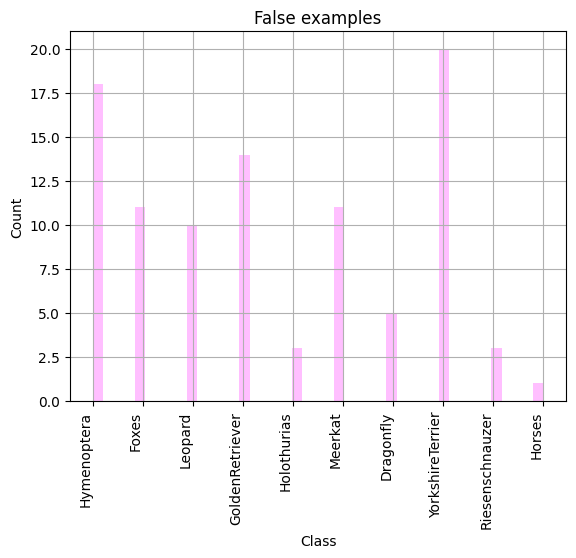

In [30]:
y_false.hist(bins=43,color='magenta', alpha=0.25)
plt.title('False examples')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.show();


Рис.9. Гистограмма ошибочной классификации

Как можем видеть из гистограммы, есть два класса, с которыми модель справляется хуже всего это YorkshireTerrier и Hymenoptera, лучше всего показывают себя классы Horses и Holothurias.

## **Этап 2. Визуализация знаний, заключенных в сверточной нейронной сети**

**Целью данного этапа** курсовой работы является исследование работы построенного многокатегориального классификатора встроенными средствами библиотек Python.

Пошаговая реализация поставленной цели
включает:

1. Загрузка модели, полученной на этапе 1:

In [2]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Conv2D

In [6]:
model = create_model()
model.load_weights('/content/drive/MyDrive/')

58889256/58889256 [==============================] - 3s 0us/step


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /content/drive/MyDrive/

In [ ]:
# model.summary()

In [7]:
import sys
sys.setrecursionlimit(1000000)

In [ ]:
from keras.preprocessing import image

2.	Проведение визуализации промежуточных активаций всех слоев для одного изображения из каждого класса:

Визуализация промежуточных выводов сверточной нейронной сети (промежуточных активаций) — помогает понять, как последовательность слоев сети преобразует свои входные данные, а также показывает смысл отдельных фильтров;


Для визуализации промежуточных активаций (выходов слоев) предобученной сверточной нейронной сети на конкретном входном изображении написана функция *visualizing_intermediate_activations*.

Функция работает следующим образом:
1. Загружается предобученная модель и отображается ее структура (summary).
2. Загружается тестовое изображение и предобрабатывается для подачи на вход модели.
3. Создается вспомогательная модель, которая извлекает выходы первых 8 слоев основной модели для данного входного изображения.
4. Визуализируется активация для одного из промежуточных слоев, показывая карту признаков для одного канала.
5. Цикл проходит через все промежуточные слои и визуализирует карты признаков для нескольких каналов каждого слоя на единичном графике.

Визуализация промежуточных активаций заключается в отображении карт признаков, которые выводятся разными сверточными и объединяющими слоями в сети в ответ на определенные входные данные (вывод слоя, результат функции активации, часто называют его активацией). Этот прием позволяет увидеть, как входные данные разлагаются на различные фильтры, полученные сетью в процессе обучения.



In [8]:
def visualizing_intermediate_activations(model):
    model.summary()
    test_image = '/content/Moskalenko/leopard/n02128385_91.JPEG' #Foxes/n02120505_9276.JPEG


    img = image.load_img(test_image, target_size=(224, 224))
    #image.l
    img_tensor = image.img_to_array(img)#image
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.# обработка данных для модели

    plt.imshow(img_tensor[0])
    plt.show()

    # Извлекает выходные данные из 8 верхних слоев:
    layer_outputs = [layer.output for layer in model.layers[1:8]]
    # Создание модели, которая вернет эти выводы с учетом заданного входа
    activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

    # Вернет список с 5 массивами Numpy по одному на активацию слоя:
    activations = activation_model.predict(img_tensor)
    # четвертый сверточный слой:
    first_layer_activation = activations[0]
    print(first_layer_activation.shape)
    print(model.layers[1:8][0].name)

    plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
    plt.show()

    # These are the names of the layers, so can have them as part of our plot
    layer_names = []
    for layer in model.layers[1:8]:
        layer_names.append(layer.name)

    images_per_row = 16

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                :, :,
                                col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                row * size: (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')

    plt.show()

Карты активаций - это карты признаков, которые генерируются различными сверточными и объединяющими (pooling) слоями сверточной нейронной сети в ответ на определенный входной сигнал (например, изображение), они  представляют собой выходы слоев сети, результаты применения функций активации к этим выходам, часто называемых просто "активациями".

Визуализация промежуточных активаций помогает понять, какие признаки и паттерны модель извлекает из входных данных на разных уровнях абстракции. Это дает представление о том, как модель "видит" и интерпретирует входные данные, что может быть полезно для отладки и улучшения производительности модели.
Кроме того, визуализация активаций может помочь выявить проблемы в обучении, такие как "мертвые" нейроны (не активирующиеся каналы) или избыточные признаки, что может привести к переобучению или неэффективному использованию вычислительных ресурсов.

In [9]:
visualizing_intermediate_activations(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

FileNotFoundError: [Errno 2] No such file or directory: '/content/Moskalenko/leopard/n02128385_91.JPEG'

Рис. 5.27. Все каналы всех активаций слоев для тестового изображения кошки

По мере подъема вверх по слоям активации становятся все более абстрактными, а их визуальная интерпретация все более сложной. Они начинают кодировать высокоуровневые понятия, такие как «кошачье ухо» или «кошачий глаз». Высокоуровневые представления несут все меньше информации об исходном изображении и все больше — о классе изображения.

Разреженность активаций увеличивается с глубиной слоя: в первом слое все фильтры активируются исходным изображением, но в последующих слоях все больше и больше остается пустых фильтров. Это означает, что шаблон, соответствующий фильтру, не обнаруживается в исходном изображении.

3. Проведение визуализации фильтров сверточной сети для одного изображения из каждого класса:

Визуализация фильтров сверточной нейронной сети — помогает точно узнать, за какой визуальный шаблон или понятие отвечает каждый фильтр;

Для визуализации фильтров предобученной сверточной нейронной сети и понимания того, как сверточные фильтры (ядра) работают и какие признаки они извлекают из входного изображения написана вспомогательная функция visualizing_convnet_filters.

Функция работает следующим образом:
1. Указывается имя слоя и индекс фильтра, который нужно визуализировать.
2. Создается функция потерь, которая максимизирует активацию выбранного фильтра для данного входного изображения.
3. Вычисляется градиент входного изображения относительно функции потерь.
4. Создается вспомогательная функция, которая выполняет восходящий градиент для входного изображения с целью максимизации активации выбранного фильтра.
5. Создается функция generate_pattern, которая генерирует образец входного изображения, максимизирующий активацию выбранного фильтра.
6. Создается сетка изображений, где каждое изображение представляет собой образец, максимизирующий активацию определенного фильтра в выбранном слое.

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def visualizing_convnet_filters(model):
    # model.summary()

    layer_name =  'block1_conv1'
    filter_index = 0

    layer_output = model.get_layer(layer_name).output
    loss = keras.backend.mean(layer_output[:, :, :, filter_index])

    # The call to `gradients` returns a list of tensors (of size 1 in this case)
    # hence we only keep the first element -- which is a tensor.
    grads = keras.backend.gradients(loss, model.input)[0]
    # We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
    grads /= (keras.backend.sqrt(keras.backend.mean(keras.backend.square(grads))) + 1e-5)
    iterate = keras.backend.function([model.input], [loss, grads])
    # Let's test it:
    loss_value, grads_value = iterate([np.zeros((1, 224, 224, 3))])
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, 224, 224, 3)) * 20 + 128.


    # Run gradient ascent for 40 steps
    step = 1.  # this is the magnitude of each gradient update
    for i in range(40):
        # Compute the loss value and gradient value
        loss_value, grads_value = iterate([input_img_data])
        # Here we adjust the input image in the direction that maximizes the loss
        input_img_data += grads_value * step


    def generate_pattern(layer_name, filter_index, size=224):
        # Build a loss function that maximizes the activation
        # of the nth filter of the layer considered.
        layer_output = model.get_layer(layer_name).output
        loss = keras.backend.mean(layer_output[:, :, :, filter_index])
        # Compute the gradient of the input picture wrt this loss
        grads = keras.backend.gradients(loss, model.input)[0]
        # Normalization trick: we normalize the gradient
        grads /= (keras.backend.sqrt(keras.backend.mean(keras.backend.square(grads))) + 1e-5)


        # This function returns the loss and grads given the input picture
        def deprocess_image(x):
            # normalize tensor: center on 0., ensure std is 0.1
            x -= x.mean()
            x /= (x.std() + 1e-5)
            x *= 0.1

            # clip to [0, 1]
            x += 0.5
            x = np.clip(x, 0, 1)

            # convert to RGB array
            x *= 255
            x = np.clip(x, 0, 255).astype('uint8')
            return x

        iterate = keras.backend.function([model.input], [loss, grads])

        # We start from a gray image with some noise
        input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

        # Run gradient ascent for 40 steps
        step = 1.
        for i in range(40):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

        img = input_img_data[0]
        return deprocess_image(img)


    # plt.imshow(generate_pattern('expanded_conv_depthwise', 5))
    # plt.show()

    # for layer_name in ['expanded_conv_depthwise']:
    #     size = 220
    #     margin = 5

    #     # This a empty (black) image where we will store our results.
    #     results = np.zeros((4 * size + 7 * margin, 4 * size + 7 * margin, 3))

    #     for i in range(4):  # iterate over the rows of our results grid
    #         for j in range(4):  # iterate over the columns of our results grid
    #             # Generate the pattern for filter `i + (j * 8)` in `layer_name`
    #             filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

    #             # Put the result in the square `(i, j)` of the results grid
    #             horizontal_start = i * size + i * margin
    #             horizontal_end = horizontal_start + size
    #             vertical_start = j * size + j * margin
    #             vertical_end = vertical_start + size
    #             results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    count = 0
    n_rows = 2
    n_columns = 2

    f, axarr = plt.subplots(nrows=n_rows, ncols=n_columns,
                            sharex=True, sharey=True,
                            figsize=(20,20))

    for row in range(n_rows):
        for column in range(n_columns):
            axarr[row, column].imshow(generate_pattern(layer_name, count, size=220))
            print(count)
            count += 1
            f.subplots_adjust(hspace=0.01, wspace=0.01)


    plt.show()



Фильтр - набор весов, которые применяются к входным данным при выполнении операции свертки. Фильтры извлекают признаки из входных данных, такие как края, текстуры, формы и т.д. Каждый фильтр в слое обучается для обнаружения определенных характеристик изображения.

отобразим визуальный шаблон, за который отвечает каждый фильтр:

0
1
2
3


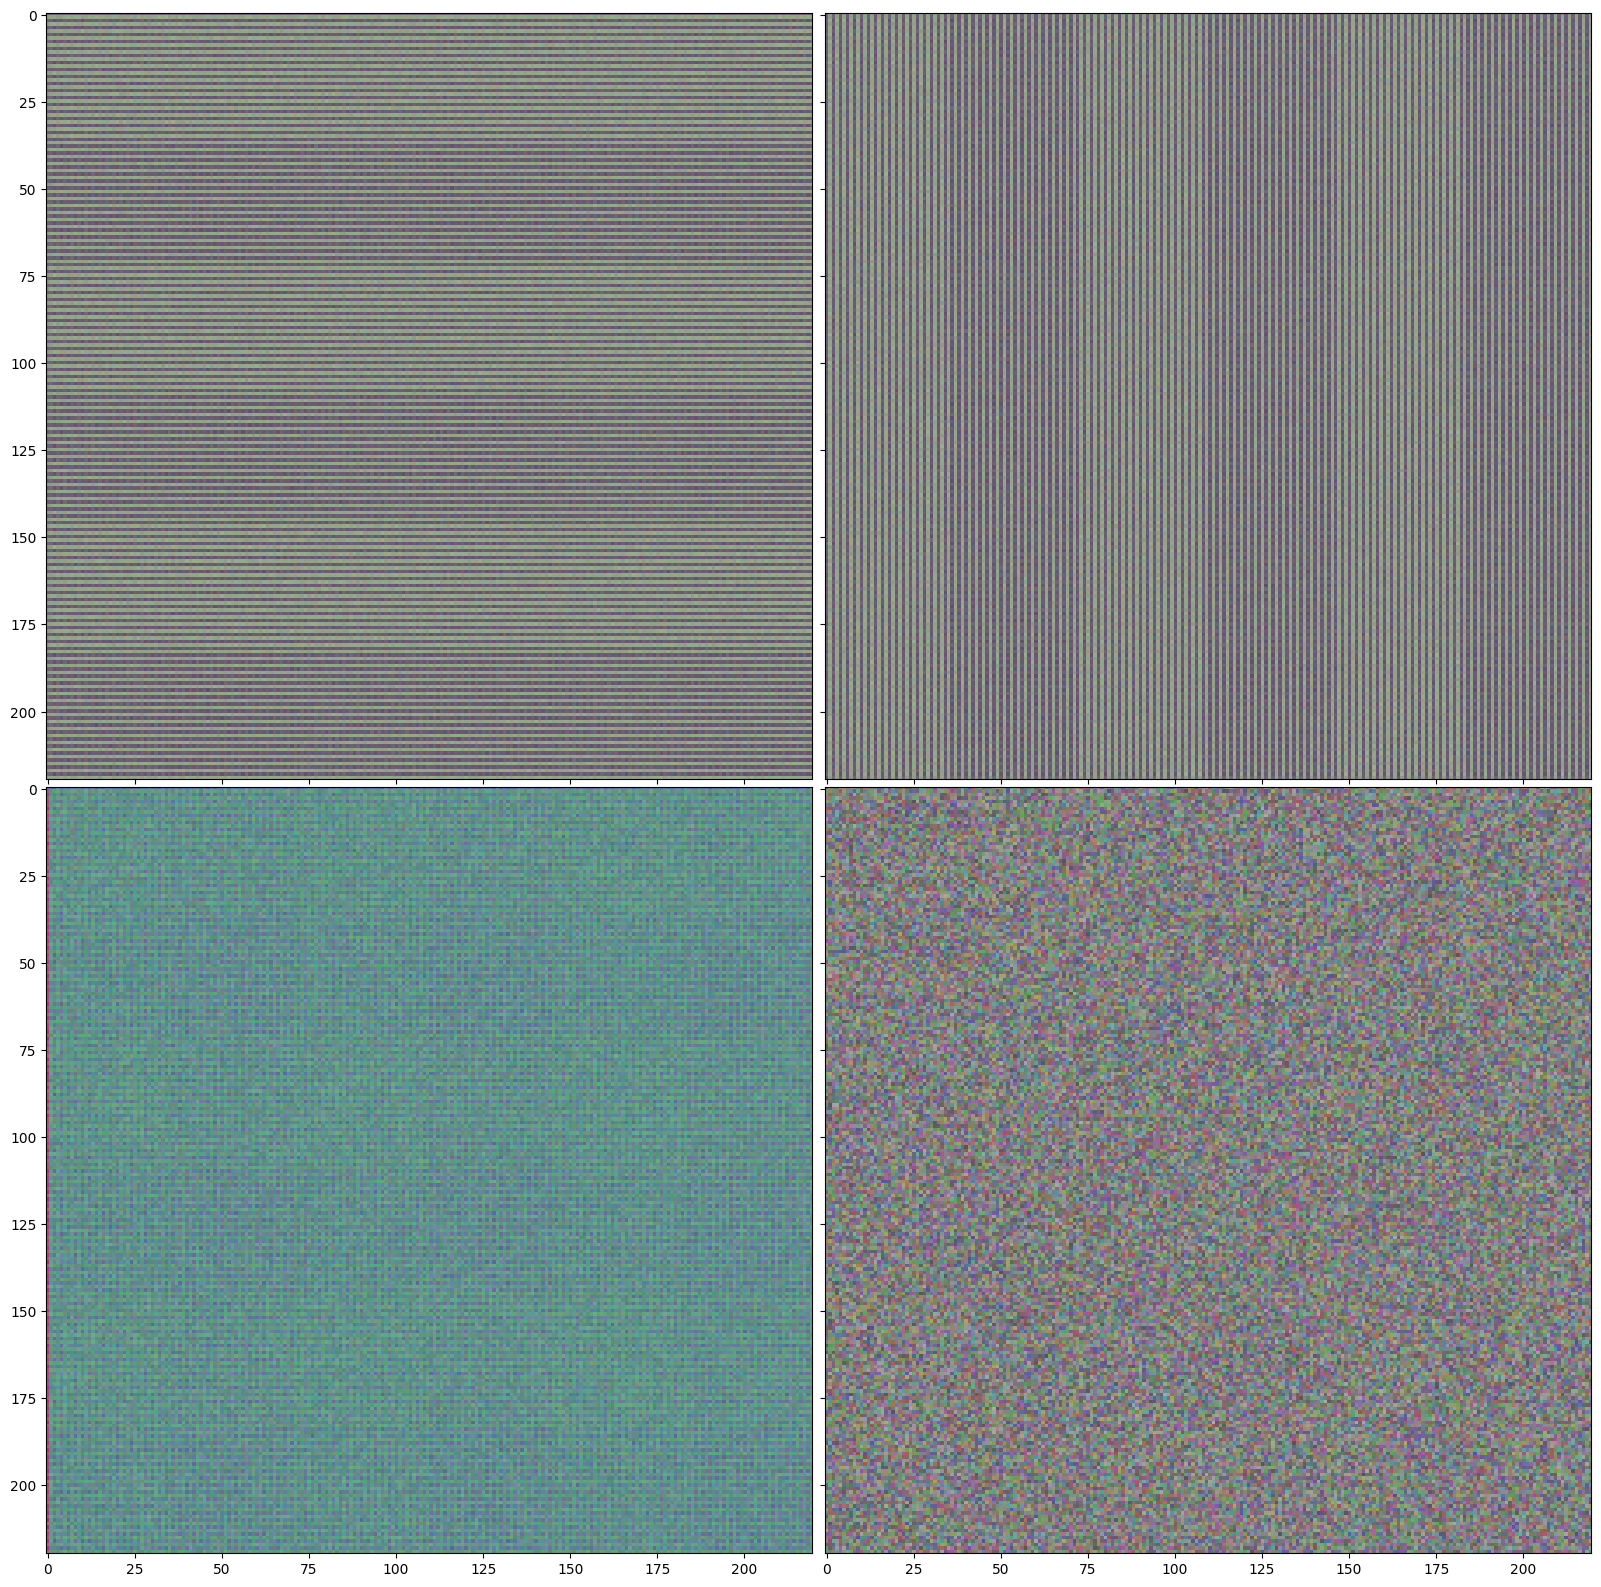

In [ ]:
visualizing_convnet_filters(model)

Рис. 5.29. Шаблоны фильтров из слоя block2_conv1

Эта визуализация помогает понять, какие визуальные признаки и паттерны извлекает каждый фильтр в сверточном слое. Изображения, полученные в результате выполнения этого кода, являются синтетическими и не имеют реального смысла, но они максимизируют активацию соответствующего фильтра, что позволяет увидеть, какие признаки он лучше всего распознает.

Визуализация фильтров может быть полезна для понимания и интерпретации того, что происходит внутри сверточной нейронной сети, а также для отладки и улучшения производительности модели. Она может помочь выявить избыточные или неэффективные фильтры, а также получить представление о том, какие визуальные признаки и паттерны модель считает важными для решения задачи.

4. Проведение визуализации тепловых карт активации класса для одного изображения из каждого класса.

Визуализация тепловых карт активации класса в изображении — помогает понять, какие части изображения идентифицируют принадлежность к заданному классу, что позволяет выявлять объекты на изображениях.

Для визуализации карты активации классов (*class activation maps, CAM*) для предобученной сверточной нейронной сети на конкретном входном изображении написана вспомогательная функция *visualizing_heatmaps_of_class_activation*.

Функция работает следующим образом:
1. Загружается входное изображение и преобразуется в формат, подходящий для модели.
2. Получаются предсказания модели для входного изображения и выбирается класс с наибольшей вероятностью.
3. Находится выходной слой модели, соответствующий выбранному классу, и извлекается выходная карта признаков последнего сверточного слоя.
4. Вычисляется градиент выходного слоя по отношению к карте признаков последнего сверточного слоя.
5. Вычисляется средняя интенсивность градиента для каждого канала карты признаков.
6. Каналы карты признаков взвешиваются соответствующими средними интенсивностями градиентов.
7. Усредняются взвешенные каналы карты признаков, создавая карту активации класса (CAM).
8. CAM нормализуется и визуализируется.
9. CAM накладывается на исходное входное изображение для создания визуализации, показывающей области изображения, которые больше всего активируют выбранный класс.
10. Результирующее изображение с наложенной CAM сохраняется на диск.


In [ ]:
import cv2
from tensorflow.python.keras.backend import set_session #
import tensorflow as tf #

graph = tf.compat.v1.get_default_graph()
sess = tf.compat.v1.Session()
set_session(sess)


def visualizing_heatmaps_of_class_activation(model):
	# Setup data paths
    img_path = '/content/Moskalenko/leopard/n02128385_91.JPEG' #Foxes/n02120505_9276.JPEG
	# Print pretrained architecture.
	# `img` is a PIL image of size 220x220
    img = image.load_img(img_path, target_size=(220, 220))

	# `x` is a float32 Numpy array of shape (220, 220, 3)
    x = image.img_to_array(img)

	# We add a dimension to transform our array into a "batch"
	# of size (1, 220, 220, 3)
    x = np.expand_dims(x, axis=0)

	# Finally we preprocess the batch
	# (this does channel-wise color normalization)
    x = preprocess_input(x)

	# Print top 3 predictions.
    with graph.as_default(): #
        set_session(sess) #
        preds = model.predict(x)[0]
    print(preds)

	# Get top1 prediction class index
	# This is entry in the prediction vector

    top1 = np.argmax(preds[0])
    output = model.output[:, top1]

	# This is the output feature map of the layer,
    last_conv_layer = model.get_layer('block5_conv3')

	# This is the gradient of the "tabby" class with regard to
	# the output feature map of `block5_conv3`
    grads = tf.keras.backend.gradients(output, last_conv_layer.output)[0]

	# This is a vector of shape (512,), where each entry
	# is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))

	# This function allows us to access the values of the quantities we just defined:
	# `pooled_grads` and the output feature map of,
	# given a sample image
    iterate = tf.keras.backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])

	# These are the values of these two quantities, as Numpy arrays,
    pooled_grads_value, conv_layer_output_value = iterate([x])

	# We multiply each channel in the feature map array
    #319 is the number of filters/channels in layer
    for i in range(512): #319
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

	# The channel-wise mean of the resulting feature map
	# is our heatmap of class activation.
    heatmap = np.mean(conv_layer_output_value, axis=-1)

	# Normalize heatmap between 0 and 1 for visualization.
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()

	# We use cv2 to load the original image
    img = cv2.imread(img_path)

	# We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

	# We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

	# We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

	# 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + img
    plt.show()


	# Save the image to disk
    cv2.imwrite("heat_map.jpg", superimposed_img)

Визуализация CAM помогает понять, какие области входного изображения наиболее важны для классификации модели в выбранный класс. Яркие области на наложенной CAM соответствуют регионам изображения, которые больше всего активируют выходной нейрон для этого класса. Это может быть полезно для интерпретации и отладки работы сверточной нейронной сети, а также для выявления областей изображения, релевантных для классификации.

[9.9995482e-01 1.1289169e-05 2.2642609e-05 2.3694931e-06 1.6102053e-06
 1.4623970e-06 1.0482023e-06 1.7666365e-07 3.5672149e-06 1.0099584e-06]


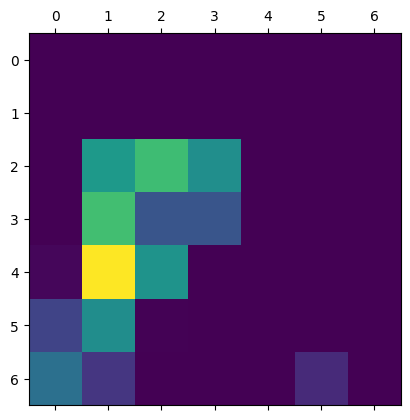

In [ ]:
visualizing_heatmaps_of_class_activation(model)

<p style="text-align: center;">Заключение</p>

1. На первом этапе мы классифицировали отзывы к фильмам на положительные и отрицательные опираясь на текст отзывов. Использовали набор данных IMDB с 50000 отзывами. Подготовили данные для передачи в сеть с помощью прямого кодирования списков, т.е. закодировали последовательности целых чисел в бинарную матрицу. Сконструировали сеть согласно варианту, состоящую из двух слоев, с 64 нейронами, функции активации скрытых слоев tanh-relu, на выходном слое Dense была использована функция sigmoid, которая на выходе дает скалярное значение в диапозоне от 0 до 1, была использована бинарная перекрестная энтропия, как функция потерь. Скомпелировали и обучили модель сначала на 20 эпохах, но появляется эффект переобучения сети после третьей эпохи, потом переобучили сеть на трех эпохах, в итоге получили модель показывающаяся точность в 88.06% при потерях в 0.29. Также предсказали вероятность пернадлежности тестовых данных.

2. На втором этапе мы классифицировали новостные ленты по их темам, опираясь на их текст. Использовали набор данных Reuters c 11228 новостей. Подготовили данные для передачи в сеть с помощью прямого кодирования как в предыдущем этапе лабораторной работы. Сконструировали сеть согласно варианту, состоящую из двух слоев, на первом слое было использовано 4 нейрона, на втором слое использовано 32 нейрона, функции активации скрытых слоев tanh-relu, на выходном слое была использована функция softmax для распределения вероятностей определения класса новосных лент, на этом этапе была использована многокатегориальная перекрестная энтропия, как функция потерь, которая определяет расстояние между распределениями вероятностей. Для нахождения оптимального количество эпох обучения было выбрано сначало 30 эпох, однако результаты и графики показали, что этого было недостаточно, потом обучили на 50 эпохах, в итоге после 43 эпохи начилось переобучение модели. Обучив модель на 43 эпохах получили точность в 71%, при потерях 1.41. Такая малая точность обусловлена малым количеством нейронов на слоях модели. Также предсказали вероятность пернадлежности тестовых данных к каждому из классов новостных лент.

3. В третьем этапе была решена задача регрессии, она выполняется с применением иных функций потерь, нежели классификация. В этой задаче Использовали набор данных boston_housing, с количеством 506 экземпляров. Обработали данные с помощью нормализации. Сконструировали сеть согласно варианту, состоящую из двух скрытых слоев, с функциями активации tanh и по 64 нейрона и заканчивается одномерным слоем (линейным слоем), не имеющим функции активации. Получается, сеть с линейным последним слоем, сеть способна предсказывать значения из любого диапазона. Скомпелировали модель с парматрами: оптимизатор - rmsprop, функция потерь: mse (среднеквадратичная ошибка) и метрику оценки mae (средняя абсолютная ошибка). Из-за малого количества данных boston_housing решили надежно оценить качество модели с помощью метода перекрестной проверки по K блокам. Обучили модель на 500 эпохах, однако при оценке обучения из-за проблем с масштабированием, а также ввиду относительно высокой дисперсии затруднительно увидеть общую тенденцию. Для оптимизации были опущены первые 60 замеров, которые имеют другой масштаб, отличный от масштаба остальной кривой, а также каждая оценка была заменена экспоненциальным скользящим средним по предыдущим оценкам. В результате переобучили модель на 150 эпох, в итоге средняя оценка ошибки прогнозирования составляет около 2372 долларов США.

<p style="text-align: center;">Список использованной литературы</p>
    1. Шолле Франсуа. Глубокое обучение на Python. - СПб.: Питер, 2018. - 400 с.: ил. - (Серия «Библиотека программиста»).